# Creazione Rete Neurale Feed Forward

## Importazione librerie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

## Preprocessing

In [2]:
file_path = "../../train.csv"
df = pd.read_csv(file_path)

In [3]:
clean_df = df.dropna() 
clean_df = df.drop_duplicates()

In [6]:
# Itera su ogni anno presente nel DataFrame
for year in clean_df['Year'].unique():
    # Filtra il DataFrame per l'anno corrente
    df_year = clean_df[clean_df['Year'] == year]
    
    # Calcola la mediana per ogni colonna
    median_values = df_year.median()
    
    # Calcola i limiti per individuare gli outlier per ogni colonna
    Q1 = df_year.quantile(0.25)
    Q3 = df_year.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Sostituisci gli outlier con la mediana per ogni colonna
    def replace_outliers(row):
        for col in df_year.columns[1:]:  # Escludi la colonna 'year'
            if row[col] < lower_limit[col] or row[col] > upper_limit[col]:
                row[col] = median_values[col]
        return row
    
    df_year = df_year.apply(replace_outliers, axis=1) # Sostituzione outlier con mediana
    
    # Sostituisci i dati nel DataFrame originale
    clean_df.loc[clean_df['Year'] == year] = df_year

In [7]:
# Seleziona solo le colonne che iniziano con 'S'
colonne_s = [col for col in clean_df.columns if col.startswith('S')]

# Lista per memorizzare i risultati originali e nuovi
risultati_outliers = []
risultati_nuovi_outliers = []

# Ciclo attraverso ogni colonna 'S'
for col in colonne_s:
    # Calcola i quantili e l'IQR (Interquartile Range) per i dati originali
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    # Calcola i baffi inferiori e superiori
    baffo_inferiore = q1 - 1.5 * iqr
    baffo_superiore = q3 + 1.5 * iqr
    
    # Trova gli outliers inferiori e superiori per i dati originali
    outliers_inferiori = df[df[col] < baffo_inferiore]
    outliers_superiori = df[df[col] > baffo_superiore]
    numero_outliers = len(outliers_inferiori) + len(outliers_superiori)
    
    # Calcola la percentuale di outliers
    percentuale_outliers = (numero_outliers / len(df)) * 100
    
    # Aggiungi i risultati alla lista
    risultati_outliers.append({
        'Colonna': col,
        'Numero outliers': numero_outliers,
        'Percentuale outliers': f'{percentuale_outliers:.2f}%'
    })
    
    # Calcola i quantili e l'IQR (Interquartile Range) per i dati modificati
    q1_new = clean_df[col].quantile(0.25)
    q3_new = clean_df[col].quantile(0.75)
    iqr_new = q3_new - q1_new
    
    # Calcola i baffi inferiori e superiori per i dati modificati
    baffo_inferiore_new = q1_new - 1.5 * iqr_new
    baffo_superiore_new = q3_new + 1.5 * iqr_new
    
    # Trova gli outliers inferiori e superiori per i dati modificati
    outliers_inferiori_new = clean_df[clean_df[col] < baffo_inferiore_new]
    outliers_superiori_new = clean_df[clean_df[col] > baffo_superiore_new]
    numero_outliers_new = len(outliers_inferiori_new) + len(outliers_superiori_new)
    
    # Calcola la percentuale di nuovi outliers
    percentuale_outliers_new = (numero_outliers_new / len(clean_df)) * 100
    
    # Aggiungi i risultati alla lista dei nuovi outliers
    risultati_nuovi_outliers.append({
        'Colonna': col,
        'Numero nuovi outliers': numero_outliers_new,
        'Percentuale nuovi outliers': f'{percentuale_outliers_new:.2f}%'
    })

# Converti le liste in DataFrame
df_outliers = pd.DataFrame(risultati_outliers)
df_nuovi_outliers = pd.DataFrame(risultati_nuovi_outliers)

# Unisci i DataFrame sui risultati originali e nuovi
outliers_summary_df = df_outliers.merge(df_nuovi_outliers, on='Colonna')

# Visualizza la tabella finale
print(outliers_summary_df)


   Colonna  Numero outliers Percentuale outliers  Numero nuovi outliers  \
0       S0             5306                2.10%                   1065   
1       S1             7313                2.90%                   1400   
2       S2             7484                2.97%                   1636   
3       S3            11229                4.45%                   2341   
4       S4             5224                2.07%                    886   
..     ...              ...                  ...                    ...   
85     S85            16608                6.59%                   5132   
86     S86            15876                6.30%                   4878   
87     S87            14794                5.87%                   4949   
88     S88            19031                7.55%                   6959   
89     S89            19330                7.67%                   8529   

   Percentuale nuovi outliers  
0                       0.42%  
1                       0.56%  
2  

In [8]:
X = clean_df.drop(columns=['Year'])  # Non la consideriamo per il modello
y = clean_df['Year'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Salva il modello di scaling
with open('scaler.save', 'wb') as f:
    pickle.dump(scaler, f)

# Rete FF

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
import seaborn as sns
import random
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Definizione dataset e modello feed forward

In [11]:
# Definizione del Data Layer
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).view(-1, 1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]
    
# Funzione per definire un modello di regressione feedforward
def feedforward_regression(input_size, hidden_size1, hidden_size2, dropout_rate, activation_function):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size1),
        nn.BatchNorm1d(hidden_size1),  # normalizzazione batch
        activation_function(),
        nn.Dropout(p=dropout_rate),
        nn.Linear(hidden_size1, hidden_size2),
        nn.BatchNorm1d(hidden_size2),  # normalizzazione batch
        activation_function(),         
        nn.Dropout(p=dropout_rate),
        nn.Linear(hidden_size2, 1)
    )
    return model

### Funzione di addestramento del modello per la regressione

In [12]:
# Funzione per l'addestramento del modello di regressione con Early Stopping
def train_model_regression(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, patience):
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    patience_counter = 0
    best_epoch = 0  # Variabile per tracciare le epoche completate

    
    # Definisci il scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            y_pred = model(data)
            loss = criterion(y_pred, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        average_loss = epoch_loss / len(train_loader)
        train_losses.append(average_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            y_val_true = []
            y_val_pred = []
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                y_pred = model(data)
                loss = criterion(y_pred, targets)
                val_loss += loss.item()
                y_val_true.append(targets.cpu())
                y_val_pred.append(y_pred.cpu())
            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)
            
                    # Calcolo metriche per ogni epoca
        y_val_true = torch.cat(y_val_true)
        y_val_pred = torch.cat(y_val_pred)
        
        val_mae = mean_absolute_error(y_val_true.numpy(), y_val_pred.numpy())
        val_mse = mean_squared_error(y_val_true.numpy(), y_val_pred.numpy())
        val_r2 = r2_score(y_val_true.numpy(), y_val_pred.numpy())
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {average_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Validation MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, R2: {val_r2:.4f}")


        # Learning Rate Scheduling
        scheduler.step(val_loss)
        
        '''
        # Early Stopping Check:
        Confronta la val_loss attuale con la best_loss trovata finora
        - Se la val_loss migliora (diminuisce), si aggiorna best_loss e si salva il modello migliore 
        - Se la val_loss non migliora per un certo numero di epoche definite dal parametro patience, l'addestramento viene interrotto
        '''
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_epoch = epoch + 1  # Aggiorniamo l'epoca migliore

            # Salva il miglior morello
            #torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    return model, train_losses, val_losses, best_epoch

# Funzione per valutare le prestazioni della rete
def test_model_regression(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            y_pred.append(model(data))
            y_test.append(targets)

    y_test = torch.cat(y_test)
    y_pred = torch.cat(y_pred)

    return y_test, y_pred

# Configurazione del dispositivo: GPU se disponibile, altrimenti CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))


Device: cpu


### Cross- validation per la ricerca degli iperparametri migliori

In [13]:
# Definizione del numero di fold per la cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definizione degli iperparametri
learning_rates = [0.1]
hidden_size1_values = [64, 128]
hidden_size2_values = [64, 128]
activation_functions = [nn.ReLU]
dropout_rate = 0.5
weight_decay = 0.01
num_epochs = 50
batch_size = 16
patience = 10

best_mse = float('inf')  # Inizializzazione del miglior MSE a un valore elevato
best_hyperparameters = {}  # Dizionario per memorizzare i migliori iperparametri

# Ottieni il numero di caratteristiche dal dataset scalato
input_size = X_train_scaled.shape[1]

# Converti y in un array numpy
y_np = y_train.values

# Ciclo di ricerca degli iperparametri tramite grid search e cross-validation
for lr in learning_rates:
    for h1 in hidden_size1_values:
        for h2 in hidden_size2_values:
            for activation_func in activation_functions:
                print(f'Training with lr={lr}, h1={h1}, h2={h2}, activation={activation_func.__name__}')

                fold_mses = []  # Lista per memorizzare il MSE di ogni fold

                # Iteriamo sui fold di cross-validation
                for train_index, val_index in kf.split(X_train_scaled):
                    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
                    y_train_fold, y_val_fold = y_np[train_index], y_np[val_index]

                    # Creazione dei DataLoader per il fold corrente
                    train_dataset = MyDataset(X_train_fold, y_train_fold)
                    val_dataset = MyDataset(X_val_fold, y_val_fold)

                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

                    # Creazione del modello con gli iperparametri correnti
                    model = feedforward_regression(input_size=input_size, hidden_size1=h1, hidden_size2=h2, dropout_rate=dropout_rate, activation_function=activation_func)
                    model.to(device)
                    criterion = nn.MSELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

                    # Addestramento del modello sul fold corrente
                    model, train_losses, val_losses, epoch = train_model_regression(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, patience)

                    # Valutazione del modello sul fold di validazione
                    model.eval()
                    with torch.no_grad():
                        val_inputs = torch.FloatTensor(X_val_fold).to(device)
                        val_targets = torch.FloatTensor(y_val_fold).view(-1, 1).to(device)
                        val_outputs = model(val_inputs)
                        val_mse = mean_squared_error(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
                        fold_mses.append(val_mse)

                # Calcolo della media del MSE su tutti i fold per gli iperparametri correnti
                avg_mse = np.mean(fold_mses)
                print(f'    Average Validation MSE: {avg_mse:.4f}')

                # Aggiornamento dei migliori iperparametri se troviamo un miglioramento
                if avg_mse < best_mse:
                    best_mse = avg_mse
                    best_hyperparameters = {
                        'learning_rate': lr,
                        'hidden_size1': h1,
                        'hidden_size2': h2,
                        'activation_function': activation_func.__name__,
                        'dropout_rate': dropout_rate,
                        'weight_decay': weight_decay,
                        'best_epoch': epoch  # Salva anche il numero di epoche ottimale
                    }

# Stampa degli iperparametri migliori trovati
print(f'Best Hyperparameters:')
print(best_hyperparameters)

Training with lr=0.1, h1=64, h2=64, activation=ReLU


Epoch 1/50, Training Loss: 69478.9744, Validation Loss: 1221.9658
Validation MAE: 29.9335, MSE: 1221.9659, R2: -9.9842
Epoch 2/50, Training Loss: 38153.2016, Validation Loss: 5433.4474
Validation MAE: 72.2690, MSE: 5433.4478, R2: -47.8409
Epoch 3/50, Training Loss: 23718.5919, Validation Loss: 1635.6333
Validation MAE: 38.8909, MSE: 1635.6333, R2: -13.7026
Epoch 4/50, Training Loss: 14128.5489, Validation Loss: 190.4684
Validation MAE: 11.9741, MSE: 190.4684, R2: -0.7121
Epoch 5/50, Training Loss: 8727.2388, Validation Loss: 252.4229
Validation MAE: 12.3965, MSE: 252.4229, R2: -1.2690
Epoch 6/50, Training Loss: 5820.8010, Validation Loss: 321.8161
Validation MAE: 16.5417, MSE: 321.8161, R2: -1.8928
Epoch 7/50, Training Loss: 4650.8396, Validation Loss: 210.8294
Validation MAE: 10.0182, MSE: 210.8295, R2: -0.8951
Epoch 8/50, Training Loss: 4175.1103, Validation Loss: 265.8889
Validation MAE: 13.8643, MSE: 265.8889, R2: -1.3901
Epoch 9/50, Training Loss: 4023.8112, Validation Loss: 180.9

### Addestramento su tutto il df

In [14]:
# Creazione del modello con gli iperparametri migliori trovati
best_model = feedforward_regression(input_size=input_size, hidden_size1=best_hyperparameters['hidden_size1'],
                                    hidden_size2=best_hyperparameters['hidden_size2'],
                                    activation_function=getattr(nn, best_hyperparameters['activation_function']),  # Converti la stringa in funzione
                                    dropout_rate=best_hyperparameters['dropout_rate'])
best_model.to(device)


optimizer = torch.optim.Adam(best_model.parameters(), lr=best_hyperparameters['learning_rate'], weight_decay=best_hyperparameters['weight_decay'])
criterion = nn.MSELoss()

# Creazione del DataLoader per l'intero dataset di training
train_dataset = MyDataset(X_train_scaled, y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Addestramento del modello con gli iperparametri migliori per il numero ottimale di epoche
trained_model, _, _, _ = train_model_regression(best_model, criterion, optimizer, best_hyperparameters['best_epoch'], train_loader, train_loader, device, patience)

# Salvataggio del modello addestrato sull'intero dataset
with open("ff.save", "wb") as file:
    pickle.dump(best_model, file)

Epoch 1/19, Training Loss: 38485.6414, Validation Loss: 508.5029
Validation MAE: 18.7605, MSE: 508.4787, R2: -3.6117
Epoch 2/19, Training Loss: 22563.4532, Validation Loss: 606.4106
Validation MAE: 17.2596, MSE: 606.4518, R2: -4.5003
Epoch 3/19, Training Loss: 16110.6406, Validation Loss: 790.2754
Validation MAE: 23.7090, MSE: 790.3044, R2: -6.1678
Epoch 4/19, Training Loss: 11790.8026, Validation Loss: 851.1956
Validation MAE: 27.4739, MSE: 851.1936, R2: -6.7200
Epoch 5/19, Training Loss: 8911.8458, Validation Loss: 3476.6377
Validation MAE: 56.9852, MSE: 3476.6448, R2: -30.5318
Epoch 6/19, Training Loss: 7274.4055, Validation Loss: 3381185.8314
Validation MAE: 1776.9208, MSE: 3381200.2500, R2: -30665.1836
Epoch 7/19, Training Loss: 6298.4221, Validation Loss: 175.6257
Validation MAE: 11.1257, MSE: 175.6339, R2: -0.5929
Epoch 8/19, Training Loss: 5837.5470, Validation Loss: 127.7098
Validation MAE: 8.8213, MSE: 127.7169, R2: -0.1583
Epoch 9/19, Training Loss: 5547.5683, Validation Los

## Confronto risultati (predizioni e reali)

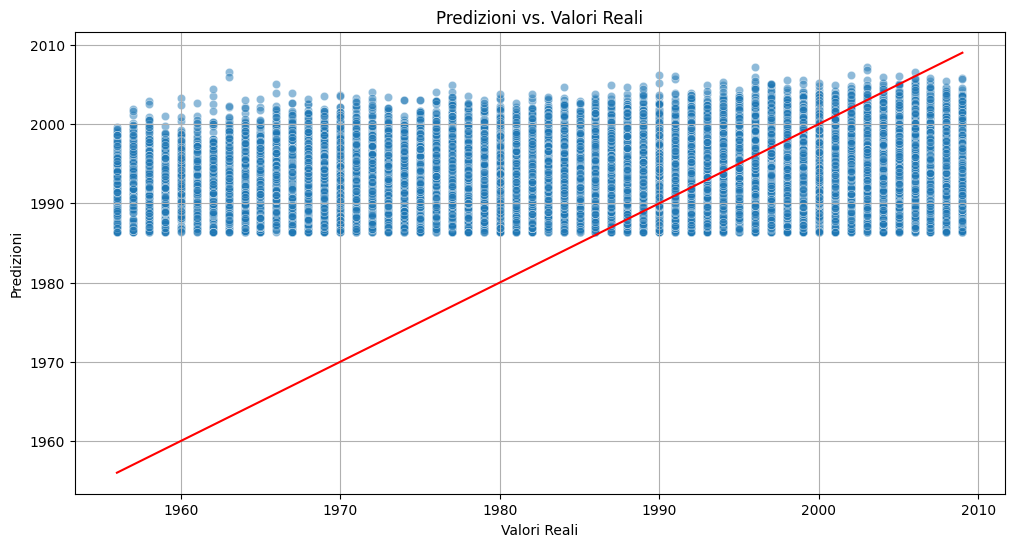

In [15]:
best_model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, labels in train_loader:  # Usa un DataLoader per i dati di test
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        predictions.extend(outputs.cpu().numpy().flatten())  # Assicurati che sia un vettore unidimensionale
        actuals.extend(labels.cpu().numpy().flatten())  # Assicurati che sia un vettore unidimensionale

# Confronto tra valori previsti e reali
plt.figure(figsize=(12, 6))
sns.scatterplot(x=actuals, y=predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red')  # Linea continua
plt.xlabel('Valori Reali')
plt.ylabel('Predizioni')
plt.title('Predizioni vs. Valori Reali')
plt.grid(True)
plt.show()